## Second attempt at a U-NET

So a UNET has three phases: contraction, bottleneck and expansion.

**Contraction**  
- Consists of repeated application of two 3x3 convolutions (unpadded), each followed by RELU-activation and then a (2x2) max pooling with stride 2.
- At each downsampling we double the number of feature channels.

**Bottleneck**

**Expansion**
- Consists of an upsampling of feature map followed by a 2x2 convolution, a concatenation with the corresponding cropped feature map from the conraction part and two 3x3 convolutions each followed by RELU-activation.
- Halves the number of feature samples.

**Final Layer**
- 1x1 convolution to obtain desired number of classes. For us only 2 (road, not road)

In [ ]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image


In [ ]:
from src.helpers import load_image

In [2]:
from skimage.transform import resize

def shape_training_data(imgs, gt_imgs):
    SIZE = (256, 256)
    n = len(imgs)
     
    imgs = [resize(img, SIZE) for img in imgs]
    gt_imgs = [resize(gt_img, SIZE) for gt_img in gt_imgs]
    
    gt_imgs = [gt_imgs[i].reshape(256, 256, 1) for i in range(n)]
    gt_imgs = [np.around(gt_imgs[i]) for i in range(n)]
    
    return np.asarray(imgs), np.asarray(gt_imgs)

def load_training_data(datapath, num_samples):
    
    image_dir = datapath + "images/"
    files = os.listdir(image_dir)
    n = min(num_samples, len(files)) # Load maximum 20 images
    
    print("Loading " + str(n) + " images")
    imgs = [load_image(image_dir + files[i]) for i in range(n)]

    gt_dir = datapath + "groundtruth/"
    print("Loading " + str(n) + " images")
    gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

    return shape_training_data(imgs, gt_imgs)


    

In [39]:
x, y = load_training_data('data/training/', 20)

x_tr = x[0:10, :, : , :]
x_te = x[10:15, :, : , :]

y_tr = y[0:10, :, : , :]
y_te = y[10:15, :, : , :]
x_tr.shape, y_tr.shape, x_te.shape, y_te.shape


Loading 20 images
Loading 20 images


((10, 256, 256, 3), (10, 256, 256, 1), (5, 256, 256, 3), (5, 256, 256, 1))

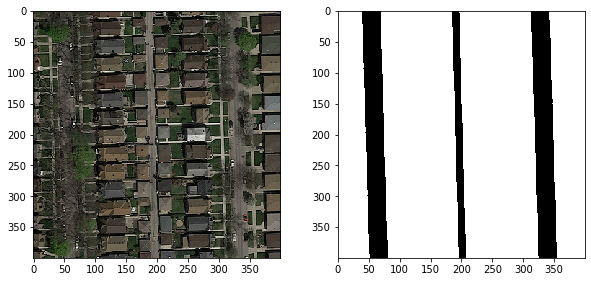

In [34]:
plt.figure(figsize = (10, 10))
plt.subplot(2,2,1)
plt.imshow(x_tr[0])

plt.subplot(2,2,2)
plt.imshow(y_tr[0].reshape(400, 400), cmap="Greys")

In [1]:
from keras.preprocessing import ImageDataGenerator

Using TensorFlow backend.


ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing' (/Users/theodor/anaconda3/envs/ml/lib/python3.7/site-packages/keras/preprocessing/__init__.py)

In [25]:
from imp import reload
import unet_class
reload(unet_class)
import unet_class

In [26]:
unet = unet_class.UNET(image_shape = (256, 256, 3), layers = 2)

In [27]:
unet.build_model()

Building model with 2 layers
Filtersizes being used in UNET: [128 256 512]
Bulding contraction layers at layer: 1 and filtersize: 128
Bulding contraction layers at layer: 2 and filtersize: 256
Building bottleneck at layer: 2 and filtersize: 512
Building expansion at layer: 2 and filtersize: 256
Building expansion at layer: 1 and filtersize: 128
Compiling model...


In [28]:
unet.describe_model()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 256, 256, 128 3584        input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 256, 256, 128 147584      conv2d_55[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 128, 128, 128 0           conv2d_56[0][0]                  
____________________________________________________________________________________________

In [29]:
epochs = 2
batch_size = 2
unet.train_model(x_tr, y_tr, x_te, y_te, epochs, batch_size)

NameError: name 'x_tr' is not defined

In [ ]:
unet.save_weights('UNET_1layer.h5')


In [30]:
from keras.models import load_model

model = load_model('model_1layer.h5')

In [31]:
model.load_weights('UNET_1layer.h5')

In [54]:
#x_te[0:1, :,:,:].shape
val = model.predict(x_te[1:2,:,:,:])

In [56]:
val.min(), val.max()

(0.17685935, 0.4790965)

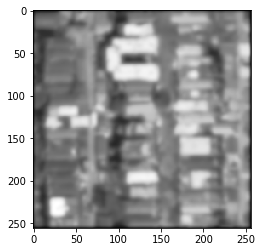

In [59]:
plt.imshow(val.reshape(256,256), cmap = "Greys")

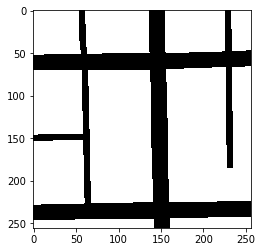

In [58]:
plt.imshow(y_te[0].reshape(256,256), cmap = "Greys")